In [1]:
def extract_substrings(text):
    substrings = []
    for i in range(1, len(text) - 4):
        if text[i] == '.':
            substrings.append(text[i-2:i+5].split("\n")[0])
    return substrings

# Read the content of the file
file_path = 'training_smaller_vs_original_20241113_171502.log'# 'training_smaller_vs_original_20241028_121920.log'
file_path = 'training_smaller_vs_original_20241028_121920.log'
file_path_full = 'training_gpt2_variant_20250509_012808.log' #original
#file_path_full = "training_gpt2_variant_20250724_190905.log"

file_path_reduced = 'training_gpt2_variant_20250716_210400.log'   #005
#file_path_reduced = 'training_gpt2_variant_20250807_171037.log'    #smaller
#file_path_reduced = "training_gpt2_variant_20250724_190905.log"  #0031
#file_path_reduced = 'training_gpt2_variant_20250621_020214.log'  #007

def opener(file_path):
    try:
        with open(file_path, 'r') as file:
            file_content = file.read()

        # Extract the desired substrings
        result = file_content

        # Print the results
    # for substring in result:
        #    print(substring)
    except FileNotFoundError:
        print(f"The file {file_path} was not found.")

    return result


import re
import numpy as np
def extract_train_val_scores(log_text):
    """
    Extract training and validation loss scores from log text.
    
    Args:
        log_text (str): Raw log text containing training information (can include newlines)
        
    Returns:
        tuple: (train_losses, val_losses, steps) where each is a list of values
    """
    
    # Pattern to match the training/validation loss lines with multiline support
    # The re.MULTILINE flag allows ^ and $ to match line boundaries
    pattern = r'Full Model: Step (\d+), Training Loss: ([\d.]+); Validation Loss: ([\d.]+)'
    
    # Find all matches using re.MULTILINE and re.DOTALL flags
    matches = re.findall(pattern, log_text, re.MULTILINE)
    
    # Extract values into separate lists
    steps = []
    train_losses = []
    val_losses = []
    
    for match in matches:
        step, train_loss, val_loss = match
        steps.append(int(step))
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
    
    return np.array(train_losses), np.array(val_losses), #steps

full_results_train, full_results_val = extract_train_val_scores(opener(file_path_full))
reduced_results_train, reduced_results_val = extract_train_val_scores(opener(file_path_reduced))

upward_cutoff = min(len(full_results_train), len(reduced_results_train), )#-25000


full_results_train = full_results_train[:upward_cutoff]
full_results_val = full_results_val[:upward_cutoff]
reduced_results_train = reduced_results_train[:upward_cutoff]
reduced_results_val = reduced_results_val[:upward_cutoff]


In [2]:
upward_cutoff

172072

In [3]:

difference_train = np.array([reduced_results_train[i]-full_results_train[i] for i in range(len(full_results_train))])
difference_val = np.array([reduced_results_val[i]-full_results_val[i] for i in range(len(full_results_val))])



In [4]:
from matplotlib import pyplot as plt 
plt.figure()
# plt.plot(reduced_results_train_smooth)
# plt.plot(full_results_train_smooth)
# print(len(full_results_train_smooth))
#plt.plot(result_reduced, label='Full Results Train')
# plt.plot(full_results_train_smooth, label='Full Results Train Smoothed', linestyle='--')
# plt.plot(reduced_results_train_smooth, label='Reduced Results Train Smoothed', linestyle='--')
# plt.plot(x_values_train, reduced_train_pred, label=f'Reduced Train Linear Fit (slope={reduced_train_coef:.2e})', linestyle='-.')
# plt.plot(x_values_train, full_train_pred, label=f'Full Train Linear Fit (slope={full_train_coef:.2e})', linestyle='-.')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Training Results')
# plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

In [15]:
cutoff = 170000
print(len(reduced_results_train))
print("TRAIN: ", np.mean(reduced_results_train[cutoff:]),np.mean(full_results_train[cutoff:]), np.mean(reduced_results_train[cutoff:])/np.mean(full_results_train[cutoff:])-1)
print("VAL: ", np.mean(reduced_results_val[cutoff:]), np.mean(full_results_val[cutoff:]), np.mean(reduced_results_val[cutoff:])/np.mean(full_results_val[cutoff:]) -1)

172072
TRAIN:  2.911949119311272 2.9019556333343264 0.003443707361391768
VAL:  2.9274119154827014 2.9159349462010224 0.003935948329928163


71873 72072


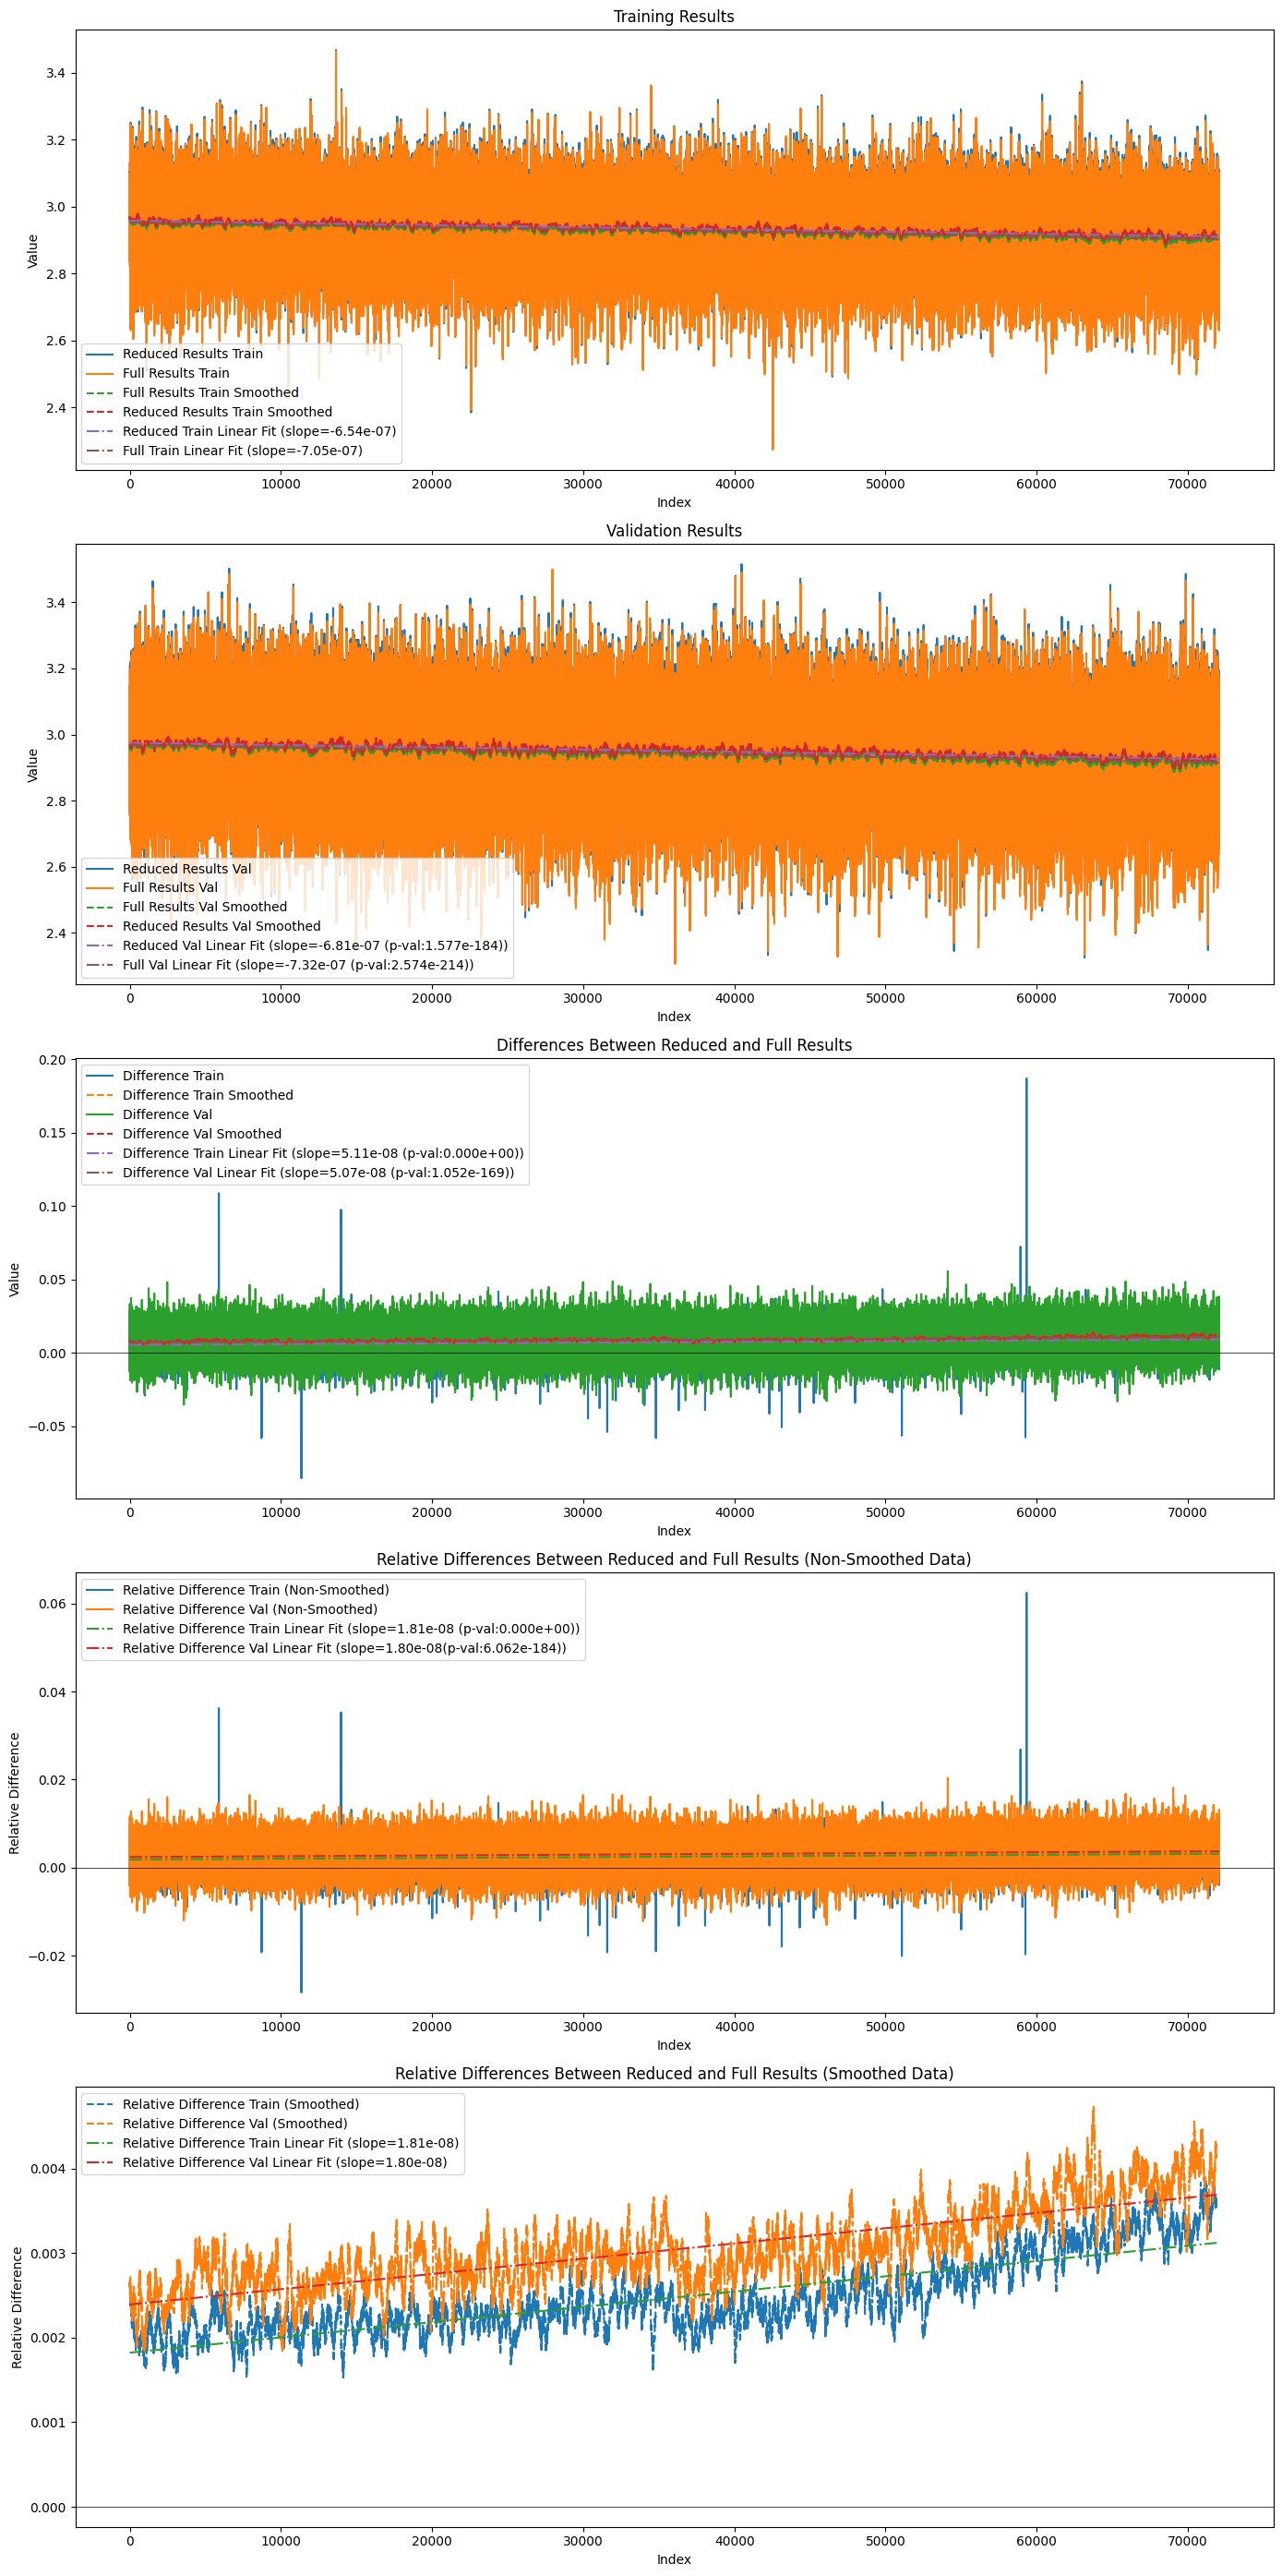

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Cutoff value
cutoff = 100000  # Adjusted cutoff value

# Smoothing function
def smooth(data, window_size=200):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply cutoff and smoothing
reduced_results_train_cutoff = reduced_results_train[cutoff:]
full_results_train_cutoff = full_results_train[cutoff:]
reduced_results_val_cutoff = reduced_results_val[cutoff:]
full_results_val_cutoff = full_results_val[cutoff:]
difference_train_cutoff = difference_train[cutoff:]
difference_val_cutoff = difference_val[cutoff:]

reduced_results_train_smooth = smooth(reduced_results_train_cutoff)
full_results_train_smooth = smooth(full_results_train_cutoff)
reduced_results_val_smooth = smooth(reduced_results_val_cutoff)
full_results_val_smooth = smooth(full_results_val_cutoff)
difference_train_smooth = smooth(difference_train_cutoff)
difference_val_smooth = smooth(difference_val_cutoff)
print(len(full_results_train_smooth), len(full_results_train_cutoff))
# Calculate relative differences for non-smoothed data
relative_diff_train_non_smoothed = (reduced_results_train_cutoff - full_results_train_cutoff) / full_results_train_cutoff
relative_diff_val_non_smoothed = (reduced_results_val_cutoff - full_results_val_cutoff) / full_results_val_cutoff


# Calculate relative differences for smoothed data
relative_diff_train_smoothed = smooth(relative_diff_train_non_smoothed)
relative_diff_val_smoothed = smooth(relative_diff_val_non_smoothed)

# Linear regression function
def linear_regression(x, y):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Add an intercept to the model
    x_with_intercept = sm.add_constant(x)
    
    # Fit the model using statsmodels
    sm_model = sm.OLS(y, x_with_intercept).fit()
    
    # Extract predictions, coefficient, intercept, and p-value
    predictions = sm_model.predict(x_with_intercept)
    coef = sm_model.params[1]
    intercept = sm_model.params[0]
    p_value = sm_model.pvalues[1]
    
    return predictions, coef, intercept, p_value

# Apply linear regression
x_values_train = np.arange(len(reduced_results_train_cutoff))
x_values_val = np.arange(len(reduced_results_val_cutoff))
x_values_diff_train = np.arange(len(difference_train_cutoff))
x_values_diff_val = np.arange(len(difference_val_cutoff))
x_values_relative_diff_train = np.arange(len(relative_diff_train_non_smoothed))
x_values_relative_diff_val = np.arange(len(relative_diff_val_non_smoothed))

reduced_train_pred, reduced_train_coef, reduced_train_intercept, reduced_train_pvalue = linear_regression(x_values_train, reduced_results_train_cutoff)
full_train_pred, full_train_coef, full_train_intercept, full_train_pvalue = linear_regression(x_values_train, full_results_train_cutoff)

reduced_val_pred, reduced_val_coef, reduced_val_intercept, reduced_val_pvalue = linear_regression(x_values_val, reduced_results_val_cutoff)
full_val_pred, full_val_coef, full_val_intercept, full_val_pvalue = linear_regression(x_values_val, full_results_val_cutoff)

diff_train_pred, diff_train_coef, diff_train_intercept, diff_train_pvalue = linear_regression(x_values_diff_train, difference_train_cutoff)
diff_val_pred, diff_val_coef, diff_val_intercept, diff_val_pvalue = linear_regression(x_values_diff_val, difference_val_cutoff)

relative_diff_train_pred, relative_diff_train_coef, relative_diff_train_intercept, relative_diff_train_pvalue = linear_regression(x_values_relative_diff_train, relative_diff_train_non_smoothed)
relative_diff_val_pred, relative_diff_val_coef, relative_diff_val_intercept, relative_diff_val_pvalue = linear_regression(x_values_relative_diff_val, relative_diff_val_non_smoothed)


# Plotting
plt.figure(figsize=(14, 28))

# Plot 1: Training Results
plt.subplot(5, 1, 1)
plt.plot(reduced_results_train_cutoff, label='Reduced Results Train')
plt.plot(full_results_train_cutoff, label='Full Results Train')
plt.plot(full_results_train_smooth, label='Full Results Train Smoothed', linestyle='--')
plt.plot(reduced_results_train_smooth, label='Reduced Results Train Smoothed', linestyle='--')
plt.plot(x_values_train, reduced_train_pred, label=f'Reduced Train Linear Fit (slope={reduced_train_coef:.2e})', linestyle='-.')
plt.plot(x_values_train, full_train_pred, label=f'Full Train Linear Fit (slope={full_train_coef:.2e})', linestyle='-.')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Training Results')
plt.legend()

# Plot 2: Validation Results
plt.subplot(5, 1, 2)
plt.plot(reduced_results_val_cutoff, label='Reduced Results Val')
plt.plot(full_results_val_cutoff, label='Full Results Val')
plt.plot(full_results_val_smooth, label='Full Results Val Smoothed', linestyle='--')
plt.plot(reduced_results_val_smooth, label='Reduced Results Val Smoothed', linestyle='--')

plt.plot(x_values_val, reduced_val_pred, label=f'Reduced Val Linear Fit (slope={reduced_val_coef:.2e} (p-val:{reduced_val_pvalue:.3e}))', linestyle='-.')
plt.plot(x_values_val, full_val_pred, label=f'Full Val Linear Fit (slope={full_val_coef:.2e} (p-val:{full_val_pvalue:.3e}))', linestyle='-.')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Validation Results')
plt.legend()

# Plot 3: Differences
plt.subplot(5, 1, 3)
plt.plot(difference_train_cutoff, label='Difference Train')
plt.plot(difference_train_smooth, label='Difference Train Smoothed', linestyle='--')
plt.plot(difference_val_cutoff, label='Difference Val')
plt.plot(difference_val_smooth, label='Difference Val Smoothed', linestyle='--')
plt.plot(x_values_diff_train, diff_train_pred, label=f'Difference Train Linear Fit (slope={diff_train_coef:.2e} (p-val:{diff_train_pvalue:.3e}))', linestyle='-.')
plt.plot(x_values_diff_val, diff_val_pred, label=f'Difference Val Linear Fit (slope={diff_val_coef:.2e} (p-val:{diff_val_pvalue:.3e}))', linestyle='-.')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Differences Between Reduced and Full Results')
plt.legend()

# Plot 4: Relative Differences (Non-Smoothed Data)
plt.subplot(5, 1, 4)
plt.plot(relative_diff_train_non_smoothed, label='Relative Difference Train (Non-Smoothed)', linestyle='-')
plt.plot(relative_diff_val_non_smoothed, label='Relative Difference Val (Non-Smoothed)', linestyle='-')
plt.plot(x_values_relative_diff_train, relative_diff_train_pred, label=f'Relative Difference Train Linear Fit (slope={relative_diff_train_coef:.2e} (p-val:{relative_diff_train_pvalue:.3e}))', linestyle='-.')
plt.plot(x_values_relative_diff_val, relative_diff_val_pred, label=f'Relative Difference Val Linear Fit (slope={relative_diff_val_coef:.2e}(p-val:{relative_diff_val_pvalue:.3e}))', linestyle='-.')

plt.axhline(y=0, color='black', linewidth=0.5)
plt.xlabel('Index')
plt.ylabel('Relative Difference')
plt.title('Relative Differences Between Reduced and Full Results (Non-Smoothed Data)')
plt.legend()

# Plot 5: Relative Differences (Smoothed Data)
plt.subplot(5, 1, 5)
plt.plot(relative_diff_train_smoothed, label='Relative Difference Train (Smoothed)', linestyle='--')
plt.plot(relative_diff_val_smoothed, label='Relative Difference Val (Smoothed)', linestyle='--')
plt.plot(x_values_relative_diff_train, relative_diff_train_pred, label=f'Relative Difference Train Linear Fit (slope={relative_diff_train_coef:.2e})', linestyle='-.')
plt.plot(x_values_relative_diff_val, relative_diff_val_pred, label=f'Relative Difference Val Linear Fit (slope={relative_diff_val_coef:.2e})', linestyle='-.')


plt.axhline(y=0, color='black', linewidth=0.5)
plt.xlabel('Index')
plt.ylabel('Relative Difference')
plt.title('Relative Differences Between Reduced and Full Results (Smoothed Data)')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
relative_diff_val_pred, relative_diff_val_coef, relative_diff_val_intercept, relative_diff_val_pred[-10:]

(array([0.00239162, 0.00239164, 0.00239166, ..., 0.00369059, 0.0036906 ,
        0.00369062]),
 1.8023933029502017e-08,
 0.002391619998634688,
 array([0.00369046, 0.00369048, 0.0036905 , 0.00369051, 0.00369053,
        0.00369055, 0.00369057, 0.00369059, 0.0036906 , 0.00369062]))

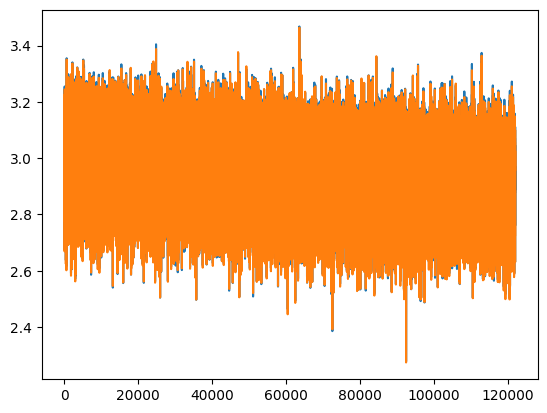

In [8]:
from matplotlib import pyplot as plt
cutoff = []
plt.plot(reduced_results_train[50000:])
plt.plot(full_results_train[50000:])
list_to_plot = reduced_results_train[10000:]

# # Apply a simple moving average for smoothing
# window_size = 200
# smoothed_difference_reduced = np.convolve(list_to_plot, np.ones(window_size)/window_size, mode='valid')
# smoothed_difference_full = np.convolve(list_to_plot, np.ones(window_size)/window_size, mode='valid')

# # Plot the smoothed data starting from the 10000th element
# plt.plot(smoothed_difference_full[cutoff-window_size+1:], label='Smoothed Data', color='red')
# plt.show()
# plt.plot(difference_train[20000:])
# plt.plot(difference_val[20000:])
# plt.show()


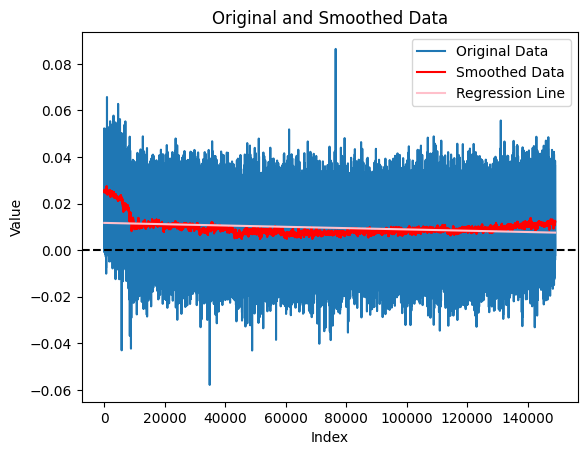

-2.799997249289036e-08 0.011677965093504626 0.0


In [9]:
import numpy as np
from scipy.stats import linregress

# Assuming 'difference' is a list of floats with more than 10000 elements
# For demonstration purposes, let's create a sample list with random floats

cutoff = 23000

list_to_plot = difference_val#[i<0 for i in difference]
# Plot the original list starting from the 10000th element
plt.plot(list_to_plot[cutoff:], label='Original Data')

# Apply a simple moving average for smoothing
window_size = 200
smoothed_difference = np.convolve(list_to_plot, np.ones(window_size)/window_size, mode='valid')

# Plot the smoothed data starting from the 10000th element
plt.plot(smoothed_difference[cutoff-window_size+1:], label='Smoothed Data', color='red')
x = np.arange(len(list_to_plot[cutoff:]))

slope, intercept, r_value, p_value, std_err = linregress(x, list_to_plot[cutoff:])
regression_line = slope * x + intercept
plt.plot(x, regression_line, label='Regression Line', color='pink')
# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original and Smoothed Data')
plt.legend()
#plt.axhline(y=0.5, color='black', linestyle='--', label='y=0')
plt.axhline(y=0.0, color='black', linestyle='--', label='y=0')
# Show the plot
plt.show()

print(slope, intercept, p_value)
#-1.2716919834954675e-05  full


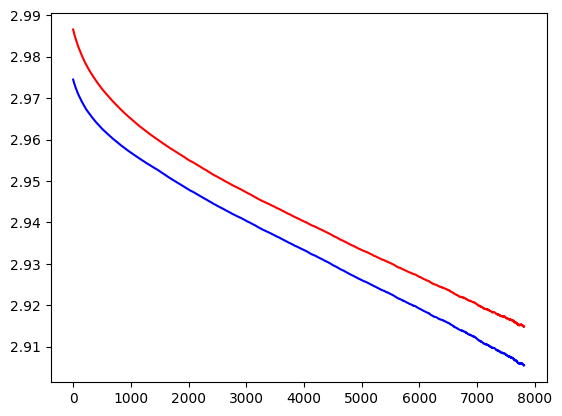

In [10]:
plt.plot([np.mean(full_results_train[2000 + 20*i:]) for i in range(len(difference_val)//20 - 40-750)], color = "blue")
plt.plot([np.mean(reduced_results_train[2000+ 20*i:]) for i in range(len(difference_val)//20 - 40-750)], color = "red")
plt.show()
#plt.axhline(y=0, color='black', linestyle='--', label='y=0')
#plt.plot([[np.mean(full_results_train[2000 + 20*i:]) for i in range(len(difference_train)//20 - 40-750)][i] -[np.mean(reduced_results_train[2000 + 20*i:]) for i in range(len(difference_train)//20 - 40-750)][i] for i in  range(len(difference_train)//20 - 40-750)])

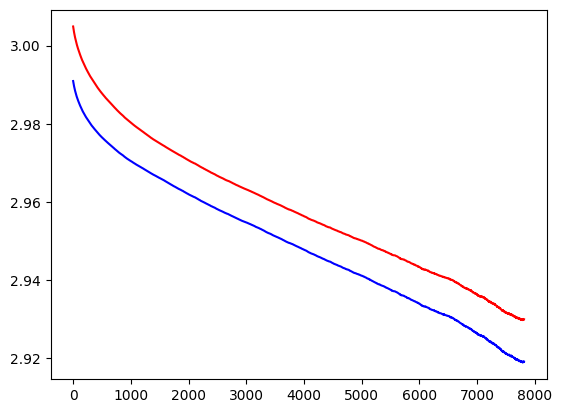

KeyboardInterrupt: 

In [11]:
plt.plot([np.mean(full_results_val[1000 + 20*i:]) for i in range(len(difference_val)//20 - 40-750)], color = "blue")
plt.plot([np.mean(reduced_results_val[1000+ 20*i:]) for i in range(len(difference_val)//20 - 40-750)], color = "red")
plt.show()
#plt.axhline(y=0, color='black', linestyle='--', label='y=0')
plt.plot([[np.mean(full_results_val[1000 + 20*i:]) for i in range(len(difference_val)//20 - 40-750)][i] -[np.mean(reduced_results_val[1000 + 20*i:]) for i in range(len(difference_train)//20 - 40-750)][i] for i in  range(len(difference_train)//20 - 40-750)])

In [ ]:
import gc
gc.collect()plt.plot([np.mean(full_results_train[10000 + 20*i:]) for i in range(len(difference_val)//20 - 40-750)], color = "blue")
plt.plot([np.mean(reduced_results_train[10000+ 20*i:]) for i in range(len(difference_val)//20 - 40-750)], color = "red")
plt.show()
#plt.axhline(y=0, color='black', linestyle='--', label='y=0')
plt.plot([[np.mean(full_results_train[10000 + 20*i:]) for i in range(len(difference_train)//20 - 40-750)][i] -[np.mean(reduced_results_train[10000 + 20*i:]) for i in range(len(difference_train)//20 - 40-750)][i] for i in  range(len(difference_train)//20 - 40-750)])

SyntaxError: invalid syntax (4047637815.py, line 2)

In [ ]:
import scipy.stats as stats

# Sample lists
lst2 = full_results_train[-12250:]
lst1 = reduced_results_train[-12250:]

# Perform a one-tailed t-test
t_statistic, p_value = stats.ttest_ind(lst1, lst2, alternative='greater')

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: mean(lst1) > mean(lst2)")
else:
    print("Fail to reject the null hypothesis: mean(lst1) <= mean(lst2)")


T-statistic: 5.701264000076734
P-value: 6.014451411339007e-09
Reject the null hypothesis: mean(lst1) > mean(lst2)
